#
**GTD TERRORISM DATA MINING PROJECT
Complete Modular Pipeline - Part 2: Preprocessing with Plug-and-Play Variants**

All preprocessing blocks with multiple strategies for experimentation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

#### BLOCK 1: FEATURE SELECTION & DATA PREPARATION

In [ ]:
def select_features_objective1(df):
    """
    Feature selection for Objective 1: Attack Type Classification

    Returns:
    --------
    X : DataFrame
        Feature matrix
    y : Series
        Target variable (attack type)
    feature_names : list
        List of feature column names
    """
    print("\n" + "="*80)
    print("BLOCK 1: FEATURE SELECTION - OBJECTIVE 1 (Attack Type Classification)")
    print("="*80)

    # Define features (15 structured columns)
    selected_features = [
        'iyear', 'imonth', 'iday',           # Temporal
        'country', 'region',                  # Geographic
        'latitude', 'longitude',              # Coordinates
        'success', 'suicide',                 # Attack characteristics
        'attacktype1',                        # Additional attack info
        'targtype1', 'targsubtype1',         # Target info
        'weaptype1', 'weapsubtype1',         # Weapon info
        'nperps'                              # Number of perpetrators
    ]

    # Target variable
    target = 'attacktype1_txt'

    # Check if columns exist
    available_features = [f for f in selected_features if f in df.columns]
    missing_features = set(selected_features) - set(available_features)

    if missing_features:
        print(f"Missing features: {missing_features}")
        print(f"   Using {len(available_features)} available features")

    X = df[available_features].copy()
    y = df[target].copy()

    print(f"Features selected: {len(available_features)}")
    print(f"   Target variable: {target}")
    print(f"   Dataset shape: {X.shape}")
    print(f"   Number of classes: {y.nunique()}")

    return X, y, available_features

#### BLOCK 2: MISSING VALUE HANDLING (PLUG-AND-PLAY POINT 1)

In [ ]:
def handle_missing_values(X, y, strategy='impute'):
    """
    Handle missing values with different strategies

    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series
        Target variable
    strategy : str
        'drop' (A1): Drop rows with missing values
        'impute' (A2): Impute with mode/median
        'impute_flag' (A3): Impute + create missing indicator flags

    Returns:
    --------
    X_processed : DataFrame
        Processed feature matrix
    y_processed : Series
        Corresponding target values
    """
    print("\n" + "="*80)
    print(f"BLOCK 2: MISSING VALUE HANDLING - Strategy: {strategy.upper()}")
    print("="*80)

    initial_shape = X.shape
    X_processed = X.copy()
    y_processed = y.copy()

    if strategy == 'drop':
        # A1: Drop rows with any missing values
        print("Strategy A1: Dropping rows with missing values...")
        mask = ~X_processed.isnull().any(axis=1)
        X_processed = X_processed[mask]
        y_processed = y_processed[mask]

        dropped = initial_shape[0] - X_processed.shape[0]
        print(f"   Dropped {dropped:,} rows ({dropped/initial_shape[0]*100:.2f}%)")

    elif strategy == 'impute':
        # A2: Simple imputation
        print("Strategy A2: Imputing missing values...")

        # Separate numerical and categorical
        num_cols = X_processed.select_dtypes(include=[np.number]).columns
        cat_cols = X_processed.select_dtypes(exclude=[np.number]).columns

        # Impute numerical with median
        if len(num_cols) > 0:
            num_imputer = SimpleImputer(strategy='median')
            X_processed[num_cols] = num_imputer.fit_transform(X_processed[num_cols])
            print(f"   Imputed {len(num_cols)} numerical features (median)")

        # Impute categorical with most frequent
        if len(cat_cols) > 0:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            X_processed[cat_cols] = cat_imputer.fit_transform(X_processed[cat_cols])
            print(f"   Imputed {len(cat_cols)} categorical features (mode)")

    elif strategy == 'impute_flag':
        # A3: Imputation + missing indicator flags
        print("Strategy A3: Imputing + creating missing flags...")

        # Create missing flags before imputation
        missing_flags = X_processed.isnull().astype(int)
        missing_flags.columns = [f'{col}_missing' for col in missing_flags.columns]

        # Add flags for columns with missing values
        cols_with_missing = missing_flags.columns[missing_flags.sum() > 0]
        if len(cols_with_missing) > 0:
            X_processed = pd.concat([X_processed, missing_flags[cols_with_missing]], axis=1)
            print(f"   Created {len(cols_with_missing)} missing indicator flags")

        # Now impute
        num_cols = X_processed.select_dtypes(include=[np.number]).columns
        cat_cols = X_processed.select_dtypes(exclude=[np.number]).columns

        # Remove flag columns from imputation
        num_cols = [col for col in num_cols if not col.endswith('_missing')]

        if len(num_cols) > 0:
            num_imputer = SimpleImputer(strategy='median')
            X_processed[num_cols] = num_imputer.fit_transform(X_processed[num_cols])

        if len(cat_cols) > 0:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            X_processed[cat_cols] = cat_imputer.fit_transform(X_processed[cat_cols])

    print(f"Final shape: {X_processed.shape}")
    print(f"   Remaining missing: {X_processed.isnull().sum().sum()}")

    return X_processed, y_processed

##### BLOCK 3: CATEGORICAL ENCODING (PLUG-AND-PLAY POINT 2)

In [ ]:
def encode_categorical_features(X, y, strategy='target', n_jobs=1):
    """
    Encode categorical features with different strategies

    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series
        Target variable (needed for target encoding)
    strategy : str
        'onehot' (C1): One-hot encoding
        'target' (C2): Target encoding
        'grouped' (C3): Grouped category encoding (reduce cardinality)

    Returns:
    --------
    X_encoded : DataFrame
        Encoded feature matrix
    """
    print("\n" + "="*80)
    print(f"BLOCK 3: CATEGORICAL ENCODING - Strategy: {strategy.upper()}")
    print("="*80)

    X_encoded = X.copy()

    # Identify categorical columns (excluding missing flags)
    cat_cols = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
    cat_cols = [col for col in cat_cols if not col.endswith('_missing')]

    if len(cat_cols) == 0:
        print("No categorical columns to encode")
        return X_encoded

    if strategy == 'onehot':
        # C1: One-hot encoding
        print(f"Strategy C1: One-hot encoding {len(cat_cols)} categorical features...")

        X_encoded = pd.get_dummies(X_encoded, columns=cat_cols, drop_first=True)
        print(f"   Created {X_encoded.shape[1] - X.shape[1]} new binary features")

    elif strategy == 'target':
        # C2: Target encoding (mean target value per category)
        print(f"Strategy C2: Target encoding {len(cat_cols)} categorical features...")

        # Encode target variable first
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        for col in cat_cols:
            # Calculate mean target value for each category
            target_means = pd.DataFrame({'cat': X_encoded[col], 'target': y_encoded}).groupby('cat')['target'].mean()

            # Map to feature
            X_encoded[col] = X_encoded[col].map(target_means)

            # Fill any missing mappings with global mean
            X_encoded[col].fillna(y_encoded.mean(), inplace=True)

        print(f"   Encoded {len(cat_cols)} features with target means")

    elif strategy == 'grouped':
        # C3: Group rare categories
        print(f"Strategy C3: Grouped encoding (reduce cardinality)...")

        threshold = 0.01  # Group categories with <1% frequency

        for col in cat_cols:
            value_counts = X_encoded[col].value_counts(normalize=True)
            rare_categories = value_counts[value_counts < threshold].index

            if len(rare_categories) > 0:
                X_encoded[col] = X_encoded[col].apply(
                    lambda x: 'OTHER' if x in rare_categories else x
                )
                print(f"   {col}: Grouped {len(rare_categories)} rare categories")

        # Now apply label encoding to all
        for col in cat_cols:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

        print(f"   Applied label encoding to grouped features")

    print(f"Encoding complete. Final shape: {X_encoded.shape}")

    return X_encoded


#### BLOCK 4: FEATURE ENGINEERING

In [ ]:
def engineer_features(X):
    """
    Create derived features

    Returns:
    --------
    X_engineered : DataFrame
        Feature matrix with engineered features
    """
    print("\n" + "="*80)
    print("BLOCK 4: FEATURE ENGINEERING")
    print("="*80)

    X_eng = X.copy()
    initial_features = X_eng.shape[1]

    # 1. Total casualties (if casualty columns exist)
    if 'nkill' in X_eng.columns and 'nwound' in X_eng.columns:
        X_eng['total_casualties'] = X_eng['nkill'].fillna(0) + X_eng['nwound'].fillna(0)
        X_eng['high_casualty'] = (X_eng['total_casualties'] > X_eng['total_casualties'].median()).astype(int)
        print("   ✓ Created: total_casualties, high_casualty")

    # 2. Temporal features
    if 'imonth' in X_eng.columns:
        X_eng['quarter'] = X_eng['imonth'].apply(lambda x: (x-1)//3 + 1 if pd.notna(x) else 0)
        X_eng['is_summer'] = X_eng['imonth'].isin([6, 7, 8]).astype(int)
        print("   ✓ Created: quarter, is_summer")

    # 3. Geographic features
    if 'latitude' in X_eng.columns and 'longitude' in X_eng.columns:
        # Distance from equator
        X_eng['lat_abs'] = X_eng['latitude'].abs()
        print("   ✓ Created: lat_abs (distance from equator)")

    # 4. Success rate indicator
    if 'success' in X_eng.columns:
        X_eng['success_binary'] = X_eng['success'].fillna(0).astype(int)
        print("   ✓ Created: success_binary")

    new_features = X_eng.shape[1] - initial_features
    print(f"Feature engineering complete. Added {new_features} new features")
    print(f"   Total features: {X_eng.shape[1]}")

    return X_eng

#### BLOCK 5: TRAIN-TEST SPLIT

In [ ]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Stratified train-test split

    Returns:
    --------
    X_train, X_test, y_train, y_test
    """
    print("\n" + "="*80)
    print("BLOCK 5: TRAIN-TEST SPLIT")
    print("="*80)

    # Identify classes with only one sample
    class_counts = y.value_counts()
    single_sample_classes = class_counts[class_counts < 2].index

    if len(single_sample_classes) > 0:
        print(f"   Warning: Found {len(single_sample_classes)} classes with less than 2 samples. Removing them for stratified split.")
        # Filter X and y to exclude these classes
        mask = ~y.isin(single_sample_classes)
        X_filtered = X[mask]
        y_filtered = y[mask]
        print(f"   Reduced dataset from {len(y)} to {len(y_filtered)} samples for splitting.")
    else:
        X_filtered = X
        y_filtered = y

    # Check if stratification is still possible after filtering
    if y_filtered.nunique() > 1 and np.min(y_filtered.value_counts()) >= 2:
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_filtered,
            test_size=test_size,
            random_state=random_state,
            stratify=y_filtered
        )
        print(f"Split completed (stratified)")
        # Verify stratification
        train_dist = y_train.value_counts(normalize=True).sort_index()
        test_dist = y_test.value_counts(normalize=True).sort_index()
        print(f"   Stratification check (max difference): {(train_dist - test_dist).abs().max():.4f}")
    else:
        print("   Warning: Stratification not possible or meaningful with remaining classes. Performing simple split.")
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_filtered,
            test_size=test_size,
            random_state=random_state,
        )
        print(f"Split completed (non-stratified)")

    print(f"   Training set: {X_train.shape[0]:,} samples ({(1-test_size)*100:.0f}%) (before balancing)")
    print(f"   Test set: {X_test.shape[0]:,} samples ({test_size*100:.0f}%) ")
    print(f"   Features: {X_train.shape[1]}")

    return X_train, X_test, y_train, y_test

#### BLOCK 6: CLASS BALANCING (PLUG-AND-PLAY POINT 3)

In [ ]:
def balance_classes(X_train, y_train, strategy='smote', random_state=42):
    """
    Balance classes with different strategies

    Parameters:
    -----------
    X_train : DataFrame/array
        Training features
    y_train : Series/array
        Training target
    strategy : str
        'none' (B1): No balancing
        'smote' (B2): SMOTE oversampling
        'weights' (B3): Return class weights (handled in model)

    Returns:
    --------
    X_balanced, y_balanced : arrays
        Balanced training data (or original if strategy='none'/'weights')
    class_weights : dict or None
        Class weights if strategy='weights', else None
    """
    print("\n" + "="*80)
    print(f"BLOCK 6: CLASS BALANCING - Strategy: {strategy.upper()}")
    print("="*80)

    initial_shape = X_train.shape
    class_weights = None

    if strategy == 'none':
        # B1: No balancing
        print("Strategy B1: No class balancing applied")
        X_balanced = X_train
        y_balanced = y_train

    elif strategy == 'smote':
        # B2: SMOTE
        print("Strategy B2: Applying SMOTE oversampling...")

        # Check minimum class size
        min_samples = y_train.value_counts().min()
        k_neighbors = min(5, min_samples - 1)

        smote = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

        print(f"   Before SMOTE: {initial_shape[0]:,} samples")
        print(f"   After SMOTE: {X_balanced.shape[0]:,} samples")
        print(f"   Increase: {X_balanced.shape[0] - initial_shape[0]:,} synthetic samples")

    elif strategy == 'weights':
        # B3: Class weights (computed but data not modified)
        print("Strategy B3: Computing class weights...")

        from sklearn.utils.class_weight import compute_class_weight

        classes = np.unique(y_train)
        weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weights = dict(zip(classes, weights))

        X_balanced = X_train
        y_balanced = y_train

        print(f"   Computed weights for {len(class_weights)} classes")
        print(f"   Weight range: {min(weights):.3f} - {max(weights):.3f}")

    print(f"Class balancing complete. Final shape: {X_balanced.shape}")

    return X_balanced, y_balanced, class_weights

#### BLOCK 7: FEATURE SCALING

In [ ]:
def scale_features(X_train, X_test):
    """
    Standardize numerical features

    Returns:
    --------
    X_train_scaled, X_test_scaled : arrays
        Scaled feature matrices
    scaler : StandardScaler
        Fitted scaler object
    """
    print("\n" + "="*80)
    print("BLOCK 7: FEATURE SCALING")
    print("="*80)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Features standardized (mean=0, std=1)")
    print(f"   Training set: {X_train_scaled.shape}")
    print(f"   Test set: {X_test_scaled.shape}")

    return X_train_scaled, X_test_scaled, scaler

In [ ]:
def run_preprocessing_pipeline(df, objective=1,
                               missing_strategy='impute',
                               encoding_strategy='target',
                               balance_strategy='smote',
                               test_size=0.2,
                               random_state=42):
    """
    Run complete preprocessing pipeline with specified strategies
    """
    print("\n" + "="*80)
    print("COMPLETE PREPROCESSING PIPELINE")
    print("="*80)
    print(f"Configuration: Missing={missing_strategy}, Encoding={encoding_strategy}, Balance={balance_strategy}")

    if objective == 1:
        X, y, features = select_features_objective1(df)

    X, y = handle_missing_values(X, y, strategy=missing_strategy)

    X = encode_categorical_features(X, y, strategy=encoding_strategy)

    X = engineer_features(X)

    X_train, X_test, y_train, y_test = split_data(X, y, test_size, random_state)

    X_train, y_train, class_weights = balance_classes(X_train, y_train, balance_strategy, random_state)

    X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

    print("\n" + "="*80)
    print("PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)

    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'class_weights': class_weights,
        'scaler': scaler,
        'feature_names': X.columns.tolist(),
        'config': {
            'objective': objective,
            'missing_strategy': missing_strategy,
            'encoding_strategy': encoding_strategy,
            'balance_strategy': balance_strategy,
            'test_size': test_size,
            'random_state': random_state
        }
    }

#
**GTD TERRORISM DATA MINING PROJECT
Complete Modular Pipeline - Part 3: Model Training & Evaluation**

Models: Random Forest, Logistic Regression, Gradient Boosting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# (Optional) if you still use learning curves or CV elsewhere
from sklearn.model_selection import train_test_split, learning_curve

import warnings
warnings.filterwarnings('ignore')


#### BLOCK 8: MODEL TRAINING

In [ ]:
def train_random_forest(X_train, y_train, class_weights=None, random_state=42):
    """
    Train Random Forest classifier

    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training labels
    class_weights : dict or None
        Class weights for imbalanced data
    random_state : int
        Random seed

    Returns:
    --------
    model : RandomForestClassifier
        Trained model
    """
    print("\n" + "="*80)
    print("BLOCK 8A: TRAINING RANDOM FOREST")
    print("="*80)

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weights if class_weights else None,
        random_state=random_state,
        n_jobs=-1,
        verbose=0
    )

    print("Hyperparameters:")
    print(f"   n_estimators: 200")
    print(f"   max_depth: 15")
    print(f"   class_weight: {'balanced' if class_weights else 'None'}")

    print("\nTraining Random Forest...")
    model.fit(X_train, y_train)

    print("Random Forest training completed!")

    return model

In [ ]:
def train_logistic_regression(X_train, y_train, class_weights=None, random_state=42):
    """
    Train Logistic Regression classifier

    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training labels
    class_weights : dict or None
        Class weights for imbalanced data
    random_state : int
        Random seed

    Returns:
    --------
    model : LogisticRegression
        Trained model
    """
    print("\n" + "="*80)
    print("BLOCK 8B: TRAINING LOGISTIC REGRESSION")
    print("="*80)

    model = LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        multi_class='multinomial',
        class_weight=class_weights if class_weights else None,
        random_state=random_state,
        n_jobs=-1,
        verbose=0
    )

    print("Hyperparameters:")
    print(f"   solver: lbfgs")
    print(f"   multi_class: multinomial")
    print(f"   max_iter: 1000")
    print(f"   class_weight: {'balanced' if class_weights else 'None'}")

    print("\n⏳ Training Logistic Regression...")
    model.fit(X_train, y_train)

    print("Logistic Regression training completed!")

    return model

In [ ]:
def train_gradient_boosting(X_train, y_train, random_state=42):
    """
    Train Gradient Boosting classifier

    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training labels
    random_state : int
        Random seed

    Returns:
    --------
    model : GradientBoostingClassifier
        Trained model
    """
    print("\n" + "="*80)
    print("BLOCK 8C: TRAINING GRADIENT BOOSTING")
    print("="*80)

    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=random_state,
        verbose=0
    )

    print("Hyperparameters:")
    print(f"   n_estimators: 100")
    print(f"   learning_rate: 0.1")
    print(f"   max_depth: 5")
    print(f"   subsample: 0.8")

    print("\nTraining Gradient Boosting...")
    model.fit(X_train, y_train)

    print("Gradient Boosting training completed!")

    return model


#### BLOCK 9: MODEL EVALUATION

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation

    Parameters:
    -----------
    model : classifier
        Trained model
    X_train, X_test : arrays
        Feature matrices
    y_train, y_test : arrays
        Target variables
    model_name : str
        Name of the model for display

    Returns:
    --------
    results : dict
        Dictionary containing all evaluation metrics
    """
    print("\n" + "="*80)
    print(f"BLOCK 9: MODEL EVALUATION - {model_name}")
    print("="*80)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    results = {
        'model_name': model_name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_macro_f1': f1_score(y_train, y_train_pred, average='macro'),
        'test_macro_f1': f1_score(y_test, y_test_pred, average='macro'),
        'train_weighted_f1': f1_score(y_train, y_train_pred, average='weighted'),
        'test_weighted_f1': f1_score(y_test, y_test_pred, average='weighted'),
        'test_precision_macro': precision_score(y_test, y_test_pred, average='macro', zero_division=0),
        'test_recall_macro': recall_score(y_test, y_test_pred, average='macro', zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, y_test_pred),
        'y_test': y_test,
        'y_pred': y_test_pred,
        'classification_report': classification_report(y_test, y_test_pred, zero_division=0)
    }

    # Display results
    print("\nPERFORMANCE METRICS:")
    print("-" * 80)
    print(f"{'Metric':<25} {'Training':<15} {'Test':<15}")
    print("-" * 80)
    print(f"{'Accuracy':<25} {results['train_accuracy']:.4f}          {results['test_accuracy']:.4f}")
    print(f"{'Macro F1-Score':<25} {results['train_macro_f1']:.4f}          {results['test_macro_f1']:.4f}")
    print(f"{'Weighted F1-Score':<25} {results['train_weighted_f1']:.4f}          {results['test_weighted_f1']:.4f}")
    print(f"{'Macro Precision':<25} {'N/A':<15} {results['test_precision_macro']:.4f}")
    print(f"{'Macro Recall':<25} {'N/A':<15} {results['test_recall_macro']:.4f}")
    print("-" * 80)

    # Check for overfitting
    overfit_score = results['train_accuracy'] - results['test_accuracy']
    if overfit_score > 0.1:
        print(f"\nPotential overfitting detected! (Gap: {overfit_score:.4f})")
    else:
        print(f"\nModel generalization looks good! (Gap: {overfit_score:.4f})")

    return results

#### VISUALIZATION FUNCTIONS

In [ ]:
def plot_confusion_matrix(cm, class_names, model_name="Model", save_path=None):
    """
    Plot confusion matrix heatmap
    """
    plt.figure(figsize=(12, 10))

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proportion'}, linewidths=0.5)

    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def plot_per_class_metrics(y_test, y_pred, class_names, model_name="Model", save_path=None):
    """
    Plot per-class precision, recall, F1-score
    """
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=class_names, zero_division=0
    )

    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 8))

    bars1 = ax.bar(x - width, precision, width, label='Precision', color='steelblue', edgecolor='black')
    bars2 = ax.bar(x, recall, width, label='Recall', color='coral', edgecolor='black')
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='lightgreen', edgecolor='black')

    ax.set_xlabel('Attack Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Class Metrics - {model_name}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.1)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_feature_importance(model, feature_names, model_name="Random Forest", top_n=15, save_path=None):
    """
    Plot feature importance (for tree-based models)
    """
    if not hasattr(model, 'feature_importances_'):
        print(f"{model_name} does not have feature_importances_ attribute")
        return

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(12, 8))
    plt.barh(range(top_n), importances[indices], color='teal', edgecolor='black')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importances - {model_name}',
              fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nTop {top_n} Most Important Features:")
    for i, idx in enumerate(indices, 1):
        print(f"   {i}. {feature_names[idx]}: {importances[idx]:.4f}")

In [ ]:
def plot_model_comparison(results_list, metric='test_accuracy', save_path=None):
    """
    Compare multiple models

    Parameters:
    -----------
    results_list : list of dicts
        List of result dictionaries from evaluate_model()
    metric : str
        Metric to compare ('test_accuracy', 'test_macro_f1', etc.)
    save_path : str
        Path to save plot
    """
    model_names = [r['model_name'] for r in results_list]
    scores = [r[metric] for r in results_list]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, scores, color=['steelblue', 'coral', 'lightgreen'],
                   edgecolor='black', linewidth=2)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.title(f'Model Comparison - {metric.replace("_", " ").title()}',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_learning_curves(model, X_train, y_train, model_name="Model", save_path=None):
    """
    Plot learning curves to diagnose bias/variance
    """
    from sklearn.model_selection import learning_curve

    print(f"\nComputing learning curves for {model_name}...")

    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='accuracy', n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, marker='o', label='Training Score', linewidth=2, color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    plt.plot(train_sizes, val_mean, marker='s', label='Validation Score', linewidth=2, color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

    plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy Score', fontsize=12, fontweight='bold')
    plt.title(f'Learning Curves - {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print("Learning curves plotted")

#### COMPLETE MODEL TRAINING & EVALUATION PIPELINE

In [ ]:
def train_and_evaluate_all_models(preprocessed_data,save_plots=True):
    """
    Train and evaluate all three models

    Parameters:
    -----------
    preprocessed_data : dict
        Output from run_preprocessing_pipeline()
    perform_cv : bool
        Whether to perform cross-validation
    save_plots : bool
        Whether to save visualization plots

    Returns:
    --------
    all_results : dict
        Dictionary containing results for all models
    """
    print("\n" + "="*80)
    print("COMPLETE MODEL TRAINING & EVALUATION PIPELINE")
    print("="*80)

    # Extract data
    X_train = preprocessed_data['X_train']
    X_test = preprocessed_data['X_test']
    y_train = preprocessed_data['y_train']
    y_test = preprocessed_data['y_test']
    class_weights = preprocessed_data['class_weights']
    feature_names = preprocessed_data['feature_names']

    all_results = {}

    # -------------------------
    # 1. RANDOM FOREST
    # -------------------------
    rf_model = train_random_forest(X_train, y_train, class_weights)
    rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

    # Visualizations
    class_names = np.unique(y_test)
    plot_confusion_matrix(rf_results['confusion_matrix'], class_names, "Random Forest",
                         'confusion_matrix_rf.png' if save_plots else None)
    plot_per_class_metrics(y_test, rf_results['y_pred'], class_names, "Random Forest",
                          'per_class_metrics_rf.png' if save_plots else None)
    plot_feature_importance(rf_model, feature_names, "Random Forest", top_n=15,
                           save_path='feature_importance_rf.png' if save_plots else None)

    all_results['random_forest'] = rf_results

    # -------------------------
    # 2. LOGISTIC REGRESSION
    # -------------------------
    lr_model = train_logistic_regression(X_train, y_train, class_weights)
    lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression")

    plot_confusion_matrix(lr_results['confusion_matrix'], class_names, "Logistic Regression",
                         'confusion_matrix_lr.png' if save_plots else None)
    plot_per_class_metrics(y_test, lr_results['y_pred'], class_names, "Logistic Regression",
                          'per_class_metrics_lr.png' if save_plots else None)

    all_results['logistic_regression'] = lr_results

    # -------------------------
    # 3. GRADIENT BOOSTING
    # -------------------------
    gb_model = train_gradient_boosting(X_train, y_train)
    gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting")

    plot_confusion_matrix(gb_results['confusion_matrix'], class_names, "Gradient Boosting",
                         'confusion_matrix_gb.png' if save_plots else None)
    plot_per_class_metrics(y_test, gb_results['y_pred'], class_names, "Gradient Boosting",
                          'per_class_metrics_gb.png' if save_plots else None)
    plot_feature_importance(gb_model, feature_names, "Gradient Boosting", top_n=15,
                           save_path='feature_importance_gb.png' if save_plots else None)

    all_results['gradient_boosting'] = gb_results

    # -------------------------
    # MODEL COMPARISON
    # -------------------------
    results_list = [rf_results, lr_results, gb_results]

    print("\n" + "="*80)
    print("FINAL MODEL COMPARISON")
    print("="*80)

    comparison_df = pd.DataFrame({
        'Model': [r['model_name'] for r in results_list],
        'Test Accuracy': [r['test_accuracy'] for r in results_list],
        'Test Macro F1': [r['test_macro_f1'] for r in results_list],
        'Test Weighted F1': [r['test_weighted_f1'] for r in results_list]
    })
    print("\n" + comparison_df.to_string(index=False))

    # Find best model
    best_idx = comparison_df['Test Macro F1'].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_score = comparison_df.loc[best_idx, 'Test Macro F1']

    print(f"\nBEST MODEL: {best_model} (Macro F1: {best_score:.4f})")

    # Comparison plots
    plot_model_comparison(results_list, 'test_accuracy',
                         'model_comparison_accuracy.png' if save_plots else None)
    plot_model_comparison(results_list, 'test_macro_f1',
                         'model_comparison_f1.png' if save_plots else None)

    all_results['comparison'] = comparison_df
    all_results['best_model'] = best_model

    return all_results

#
(Optional- run only when you want to check all combinations)
**GTD TERRORISM DATA MINING PROJECT
Complete Modular Pipeline - Part 4: Experimental Framework**

Run all 27 preprocessing combinations and compare results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#### EXPERIMENTAL CONFIGURATION

In [ ]:
EXPERIMENT_CONFIG = {
    'missing_strategies': ['drop', 'impute', 'impute_flag'],  # A1, A2, A3
    'encoding_strategies': ['onehot', 'target', 'grouped'],    # C1, C2, C3
    'balance_strategies': ['none', 'smote', 'weights'],        # B1, B2, B3
}

In [ ]:
# Generate all 27 combinations
def generate_experiment_combinations():
    """Generate all 27 preprocessing combinations"""
    combinations = list(product(
        EXPERIMENT_CONFIG['missing_strategies'],
        EXPERIMENT_CONFIG['encoding_strategies'],
        EXPERIMENT_CONFIG['balance_strategies']
    ))

    experiments = []
    for i, (miss, enc, bal) in enumerate(combinations, 1):
        exp_id = f"EXP{i:02d}"
        exp_name = f"{miss[:4].upper()}-{enc[:4].upper()}-{bal[:4].upper()}"
        experiments.append({
            'exp_id': exp_id,
            'exp_name': exp_name,
            'missing': miss,
            'encoding': enc,
            'balance': bal
        })

    return experiments

#### EXPERIMENT RUNNER

In [ ]:
def run_single_experiment(df, exp_config, objective=1, model_type='random_forest',
                         random_state=42, verbose=True):
    """
    Run a single experiment with specified configuration
    """
    # DELETE these lines now that all code is in one notebook/file:
    # from gtd_pipeline_part2 import run_preprocessing_pipeline
    # from gtd_pipeline_part3 import (train_random_forest, train_logistic_regression,
    #                                  train_gradient_boosting, evaluate_model)

    if verbose:
        print(f"\n{'='*80}")
        print(f"Running Experiment: {exp_config['exp_id']} - {exp_config['exp_name']}")
        print(f"{'='*80}")

    start_time = time.time()

    try:
        # Preprocessing
        preprocessed = run_preprocessing_pipeline(
            df,
            objective=objective,
            missing_strategy=exp_config['missing'],
            encoding_strategy=exp_config['encoding'],
            balance_strategy=exp_config['balance'],
            test_size=0.2,
            random_state=random_state
        )

        X_train = preprocessed['X_train']
        X_test = preprocessed['X_test']
        y_train = preprocessed['y_train']
        y_test = preprocessed['y_test']
        class_weights = preprocessed['class_weights']

        # Train model
        if model_type == 'random_forest':
            model = train_random_forest(X_train, y_train, class_weights, random_state)
        elif model_type == 'logistic_regression':
            model = train_logistic_regression(X_train, y_train, class_weights, random_state)
        elif model_type == 'gradient_boosting':
            model = train_gradient_boosting(X_train, y_train, random_state)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        # Evaluate
        eval_results = evaluate_model(
            model, X_train, X_test, y_train, y_test,
            f"{exp_config['exp_id']}-{model_type}"
        )

        elapsed_time = time.time() - start_time
        results = {
            'exp_id': exp_config['exp_id'],
            'exp_name': exp_config['exp_name'],
            'config': exp_config,
            'model_type': model_type,
            'train_samples': len(y_train),
            'test_samples': len(y_test),
            'n_features': X_train.shape[1],
            'train_accuracy': eval_results['train_accuracy'],
            'test_accuracy': eval_results['test_accuracy'],
            'test_macro_f1': eval_results['test_macro_f1'],
            'test_weighted_f1': eval_results['test_weighted_f1'],
            'test_precision': eval_results['test_precision_macro'],
            'test_recall': eval_results['test_recall_macro'],
            'training_time': elapsed_time,
            'status': 'SUCCESS'
        }
        if verbose:
            print(f"Experiment completed in {elapsed_time:.2f}s")
            print(f"   Test Accuracy: {results['test_accuracy']:.4f}")
            print(f"   Test Macro F1: {results['test_macro_f1']:.4f}")
        return results

    except Exception as e:
        if verbose:
            print(f"Experiment failed: {str(e)}")
        return {
            'exp_id': exp_config['exp_id'],
            'exp_name': exp_config['exp_name'],
            'config': exp_config,
            'model_type': model_type,
            'status': 'FAILED',
            'error': str(e),
            'training_time': time.time() - start_time
        }


In [ ]:
def run_all_experiments(df, objective=1, model_type='random_forest',
                       random_state=42, save_results=True):
    """
    Run all 27 experiments

    Parameters:
    -----------
    df : DataFrame
        Raw GTD data
    objective : int
        1 for attack type, 2 for hotspot
    model_type : str
        Model to use for all experiments
    random_state : int
        Random seed
    save_results : bool
        Save results to CSV

    Returns:
    --------
    results_df : DataFrame
        Results for all experiments
    """
    print("\n" + "="*80)
    print("RUNNING ALL 27 PREPROCESSING EXPERIMENTS")
    print("="*80)
    print(f"Objective: {objective}")
    print(f"Model: {model_type}")
    print(f"Total experiments: 27")
    print("="*80)

    experiments = generate_experiment_combinations()
    all_results = []

    for i, exp in enumerate(experiments, 1):
        print(f"\n[{i}/27] Starting {exp['exp_id']}...")

        result = run_single_experiment(
            df, exp, objective, model_type, random_state, verbose=False
        )
        all_results.append(result)

        # Print summary
        if result['status'] == 'SUCCESS':
            print(f"{exp['exp_id']}: Acc={result['test_accuracy']:.4f}, "
                  f"F1={result['test_macro_f1']:.4f}, Time={result['training_time']:.1f}s")
        else:
            print(f"{exp['exp_id']}: FAILED - {result.get('error', 'Unknown error')}")

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)

    # Save results
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"experiment_results_{model_type}_obj{objective}_{timestamp}.csv"
        results_df.to_csv(filename, index=False)
        print(f"\nResults saved to: {filename}")

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED")
    print("="*80)

    return results_df

#### EXPERIMENT ANALYSIS & VISUALIZATION

In [ ]:
def analyze_experiment_results(results_df, save_plots=True):
    """
    Comprehensive analysis of all experiment results
    """
    print("\n" + "="*80)
    print("EXPERIMENT RESULTS ANALYSIS")
    print("="*80)

    # Filter successful experiments
    success_df = results_df[results_df['status'] == 'SUCCESS'].copy()
    n_success = len(success_df)
    n_failed = len(results_df) - n_success

    print(f"\nSuccess Rate: {n_success}/{len(results_df)} ({n_success/len(results_df)*100:.1f}%)")
    if n_failed > 0:
        print(f"Failed: {n_failed}")

    if n_success == 0:
        print("No successful experiments to analyze!")
        return

    # 1. Summary statistics
    print("\n" + "-"*80)
    print("SUMMARY STATISTICS")
    print("-" + "-"*80)

    metrics = ['test_accuracy', 'test_macro_f1', 'test_weighted_f1', 'training_time']
    summary = success_df[metrics].describe()
    print(summary)

    # 2. Best and worst configurations
    print("\n" + "-"*80)
    print("TOP 5 BEST CONFIGURATIONS (by Macro F1)")
    print("-" + "-"*80)

    best_5 = success_df.nlargest(5, 'test_macro_f1')[
        ['exp_id', 'exp_name', 'test_accuracy', 'test_macro_f1', 'test_weighted_f1']
    ]
    print(best_5.to_string(index=False))

    print("\n" + "-"*80)
    print("TOP 5 WORST CONFIGURATIONS (by Macro F1)")
    print("-" + "-"*80)

    worst_5 = success_df.nsmallest(5, 'test_macro_f1')[
        ['exp_id', 'exp_name', 'test_accuracy', 'test_macro_f1', 'test_weighted_f1']
    ]
    print(worst_5.to_string(index=False))

    # 3. Strategy-wise analysis
    print("\n" + "-"*80)
    print("STRATEGY-WISE PERFORMANCE")
    print("-" + "-"*80)

    # Extract strategies from config
    success_df['missing_strategy'] = success_df['config'].apply(lambda x: x['missing'])
    success_df['encoding_strategy'] = success_df['config'].apply(lambda x: x['encoding'])
    success_df['balance_strategy'] = success_df['config'].apply(lambda x: x['balance'])

    for strategy_type in ['missing_strategy', 'encoding_strategy', 'balance_strategy']:
        print(f"\n{strategy_type.replace('_', ' ').title()}:")
        strategy_means = success_df.groupby(strategy_type)['test_macro_f1'].agg(['mean', 'std', 'count'])
        print(strategy_means)

    # Visualizations
    visualize_experiment_results(success_df, save_plots)

    return success_df

In [ ]:
def visualize_experiment_results(success_df, save_plots=True):
    """
    Create comprehensive visualizations of experiment results
    """
    print("\nGenerating visualizations...")

    # 1. Overall performance comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy comparison
    exp_names_short = [name[:12] for name in success_df['exp_name']]
    colors = sns.color_palette("husl", len(success_df))

    axes[0, 0].barh(range(len(success_df)), success_df['test_accuracy'], color=colors)
    axes[0, 0].set_yticks(range(len(success_df)))
    axes[0, 0].set_yticklabels(success_df['exp_id'], fontsize=8)
    axes[0, 0].set_xlabel('Test Accuracy')
    axes[0, 0].set_title('Test Accuracy by Experiment', fontweight='bold')
    axes[0, 0].axvline(success_df['test_accuracy'].mean(), color='red',
                       linestyle='--', label='Mean', linewidth=2)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='x', alpha=0.3)

    # Macro F1 comparison
    axes[0, 1].barh(range(len(success_df)), success_df['test_macro_f1'], color=colors)
    axes[0, 1].set_yticks(range(len(success_df)))
    axes[0, 1].set_yticklabels(success_df['exp_id'], fontsize=8)
    axes[0, 1].set_xlabel('Test Macro F1')
    axes[0, 1].set_title('Test Macro F1 by Experiment', fontweight='bold')
    axes[0, 1].axvline(success_df['test_macro_f1'].mean(), color='red',
                       linestyle='--', label='Mean', linewidth=2)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)

    # Training time
    axes[1, 0].barh(range(len(success_df)), success_df['training_time'], color=colors)
    axes[1, 0].set_yticks(range(len(success_df)))
    axes[1, 0].set_yticklabels(success_df['exp_id'], fontsize=8)
    axes[1, 0].set_xlabel('Training Time (seconds)')
    axes[1, 0].set_title('Training Time by Experiment', fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Accuracy vs F1 scatter
    axes[1, 1].scatter(success_df['test_accuracy'], success_df['test_macro_f1'],
                      s=100, c=range(len(success_df)), cmap='viridis',
                      edgecolors='black', linewidth=1.5)
    axes[1, 1].set_xlabel('Test Accuracy')
    axes[1, 1].set_ylabel('Test Macro F1')
    axes[1, 1].set_title('Accuracy vs Macro F1', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    # Add best point annotation
    best_idx = success_df['test_macro_f1'].idxmax()
    axes[1, 1].annotate(success_df.loc[best_idx, 'exp_id'],
                       xy=(success_df.loc[best_idx, 'test_accuracy'],
                           success_df.loc[best_idx, 'test_macro_f1']),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round', fc='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.tight_layout()
    if save_plots:
        plt.savefig('experiment_overview.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Strategy comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    strategies = [
        ('missing_strategy', 'Missing Value Strategy'),
        ('encoding_strategy', 'Encoding Strategy'),
        ('balance_strategy', 'Balance Strategy')
    ]

    for idx, (col, title) in enumerate(strategies):
        strategy_stats = success_df.groupby(col)['test_macro_f1'].agg(['mean', 'std'])

        axes[idx].bar(strategy_stats.index, strategy_stats['mean'],
                     yerr=strategy_stats['std'], capsize=5,
                     color=sns.color_palette("Set2", len(strategy_stats)),
                     edgecolor='black', linewidth=1.5)
        axes[idx].set_ylabel('Test Macro F1')
        axes[idx].set_title(title, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].set_ylim(0, 1)

        # Rotate x labels if needed
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    if save_plots:
        plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Heatmap of strategy combinations
    pivot_data = success_df.pivot_table(
        values='test_macro_f1',
        index='missing_strategy',
        columns='encoding_strategy',
        aggfunc='mean'
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlGnBu',
                cbar_kws={'label': 'Mean Macro F1'}, linewidths=1)
    plt.title('Missing Strategy × Encoding Strategy Performance',
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    if save_plots:
        plt.savefig('strategy_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Visualizations completed")

#### STATISTICAL SIGNIFICANCE TESTING

In [ ]:
def statistical_comparison(results_df):
    """
    Perform statistical tests to compare strategies
    """
    from scipy import stats

    print("\n" + "="*80)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*80)

    success_df = results_df[results_df['status'] == 'SUCCESS'].copy()
    success_df['missing_strategy'] = success_df['config'].apply(lambda x: x['missing'])
    success_df['encoding_strategy'] = success_df['config'].apply(lambda x: x['encoding'])
    success_df['balance_strategy'] = success_df['config'].apply(lambda x: x['balance'])

    strategies = ['missing_strategy', 'encoding_strategy', 'balance_strategy']

    for strategy in strategies:
        print(f"\n{strategy.replace('_', ' ').title()}:")
        print("-" * 80)

        groups = success_df.groupby(strategy)['test_macro_f1'].apply(list)

        # ANOVA test
        if len(groups) > 2:
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"ANOVA: F-statistic={f_stat:.4f}, p-value={p_value:.4f}")

            if p_value < 0.05:
                print("Significant difference detected between strategies (p < 0.05)")
            else:
                print("No significant difference between strategies (p >= 0.05)")

#
RUNNING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/globalterrorismdb_0522dist.xlsx')

In [ ]:
print(df.shape)
print(df.columns[:10])

(209706, 135)
Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region'],
      dtype='object')


Run all models for each objective

In [ ]:
# Choose preprocessing settings to try
missing  = 'impute'       # or 'drop', 'impute_flag'
encoding = 'target'       # or 'onehot', 'grouped'
balance  = 'smote'        # or 'none', 'weights'


COMPLETE PREPROCESSING PIPELINE
Configuration: Missing=impute, Encoding=target, Balance=smote

BLOCK 1: FEATURE SELECTION - OBJECTIVE 1 (Attack Type Classification)
Features selected: 15
   Target variable: attacktype1_txt
   Dataset shape: (209706, 15)
   Number of classes: 9

BLOCK 2: MISSING VALUE HANDLING - Strategy: IMPUTE
Strategy A2: Imputing missing values...
   Imputed 15 numerical features (median)
Final shape: (209706, 15)
   Remaining missing: 0

BLOCK 3: CATEGORICAL ENCODING - Strategy: TARGET
No categorical columns to encode

BLOCK 4: FEATURE ENGINEERING
   ✓ Created: quarter, is_summer
   ✓ Created: lat_abs (distance from equator)
   ✓ Created: success_binary
Feature engineering complete. Added 4 new features
   Total features: 19

BLOCK 5: TRAIN-TEST SPLIT
Split completed (stratified)
   Stratification check (max difference): 0.0000
   Training set: 167,764 samples (80%) (before balancing)
   Test set: 41,942 samples (20%) 
   Features: 19

BLOCK 6: CLASS BALANCING - S

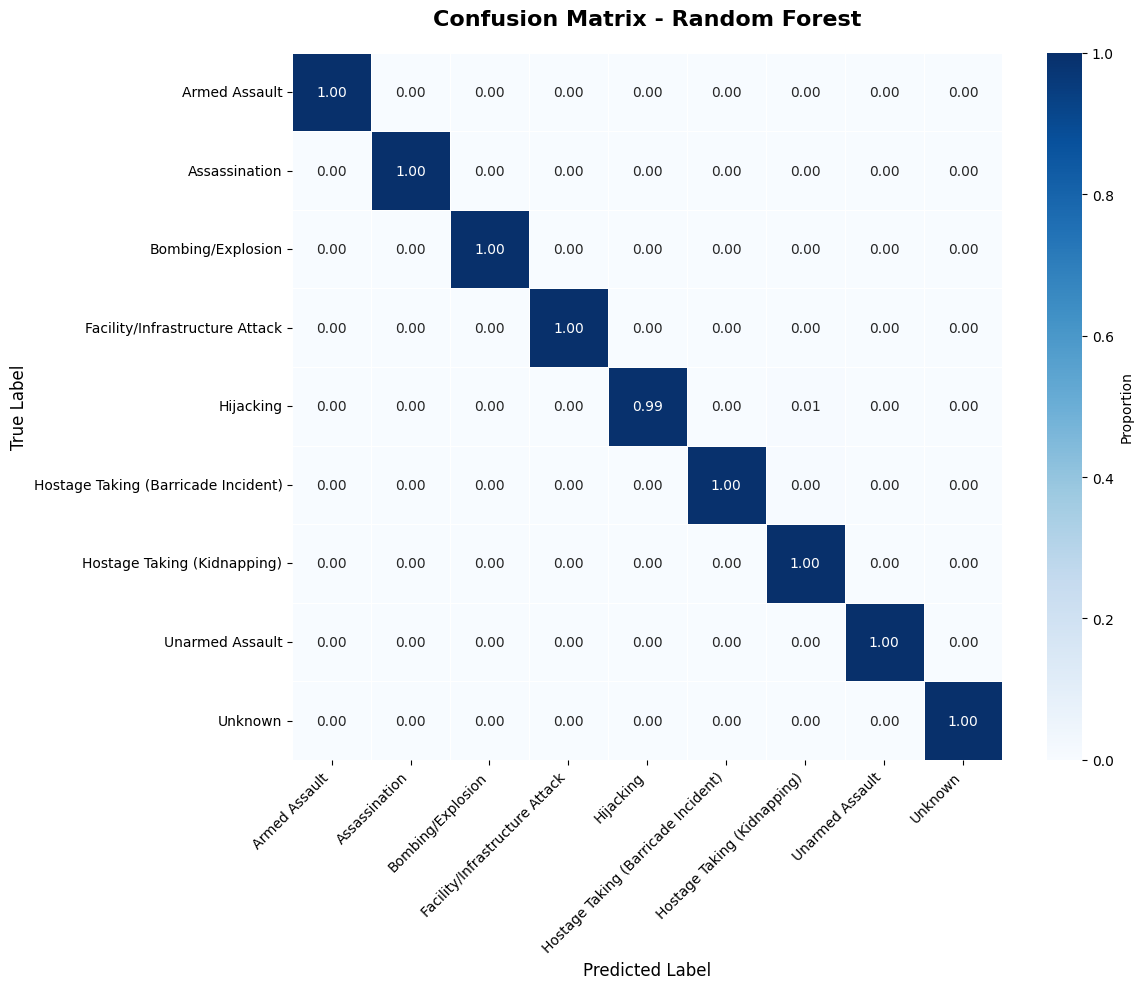

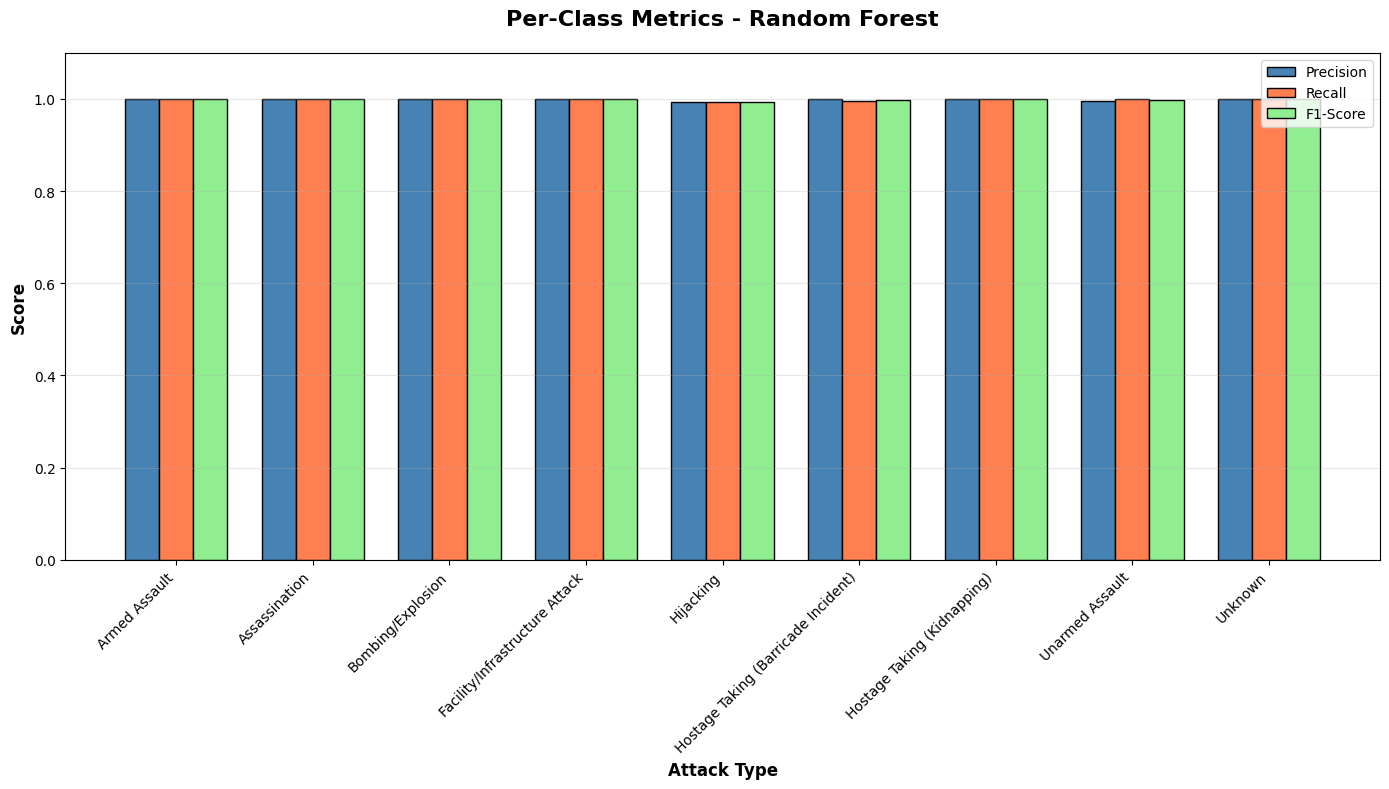

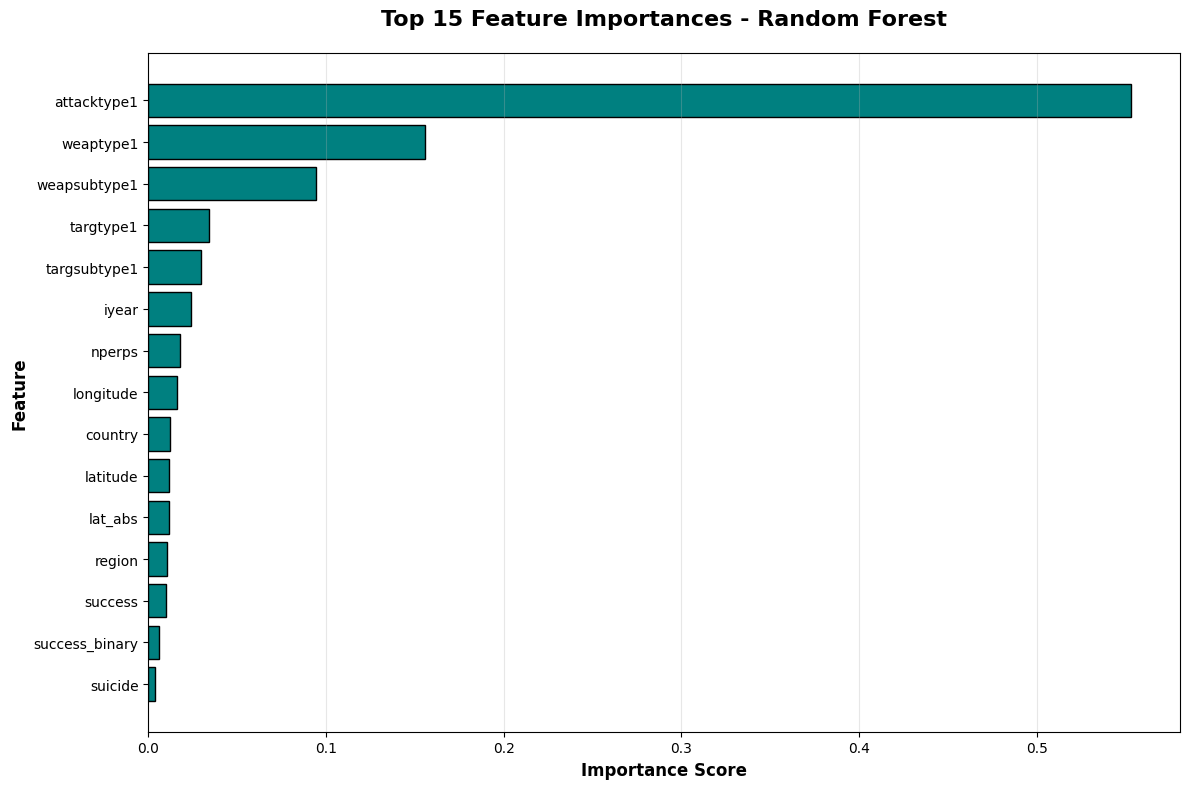


Top 15 Most Important Features:
   1. attacktype1: 0.5530
   2. weaptype1: 0.1555
   3. weapsubtype1: 0.0941
   4. targtype1: 0.0344
   5. targsubtype1: 0.0299
   6. iyear: 0.0243
   7. nperps: 0.0180
   8. longitude: 0.0163
   9. country: 0.0120
   10. latitude: 0.0119
   11. lat_abs: 0.0118
   12. region: 0.0103
   13. success: 0.0100
   14. success_binary: 0.0062
   15. suicide: 0.0036

BLOCK 8B: TRAINING LOGISTIC REGRESSION
Hyperparameters:
   solver: lbfgs
   multi_class: multinomial
   max_iter: 1000
   class_weight: None

⏳ Training Logistic Regression...
Logistic Regression training completed!

BLOCK 9: MODEL EVALUATION - Logistic Regression

PERFORMANCE METRICS:
--------------------------------------------------------------------------------
Metric                    Training        Test           
--------------------------------------------------------------------------------
Accuracy                  0.9999          0.9999
Macro F1-Score            0.9999          0.9986
W

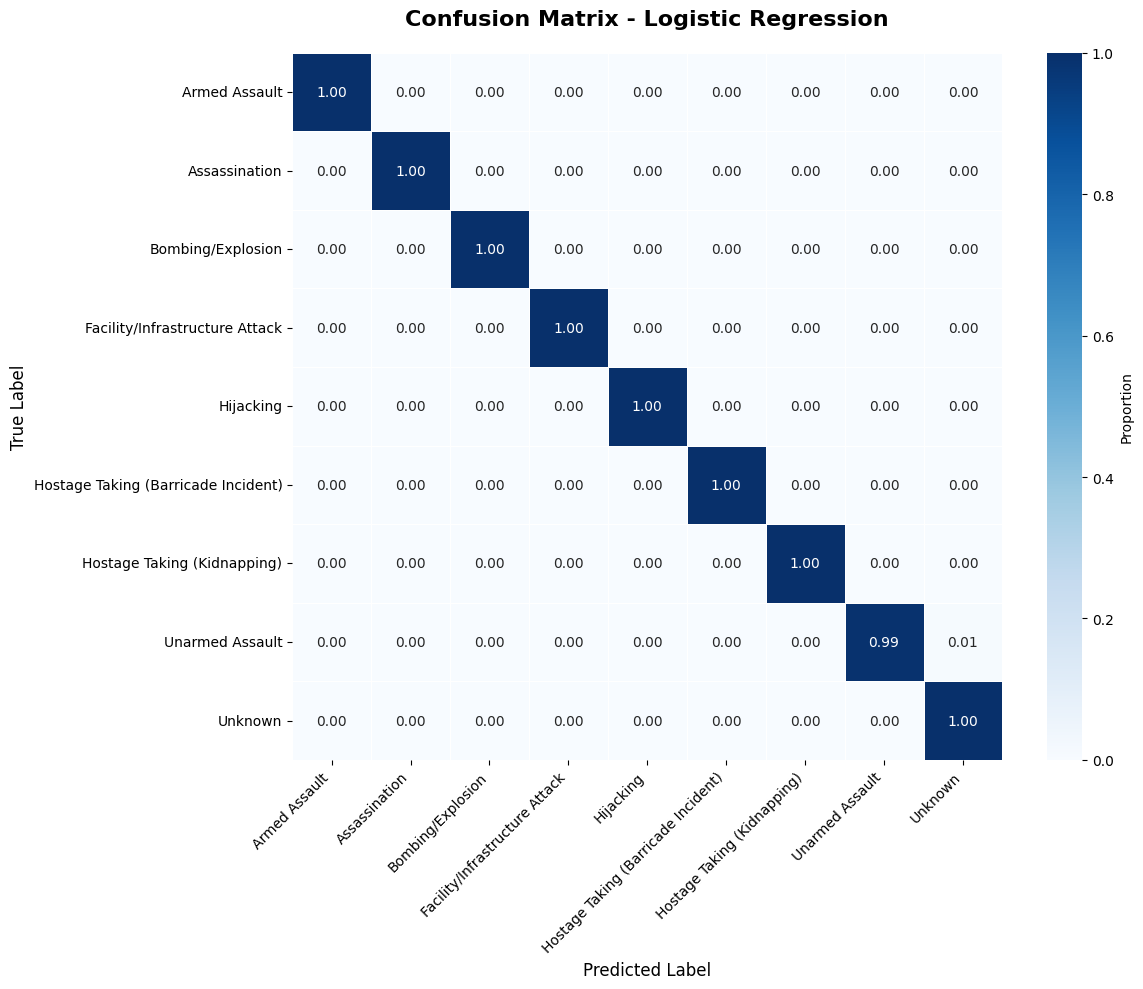

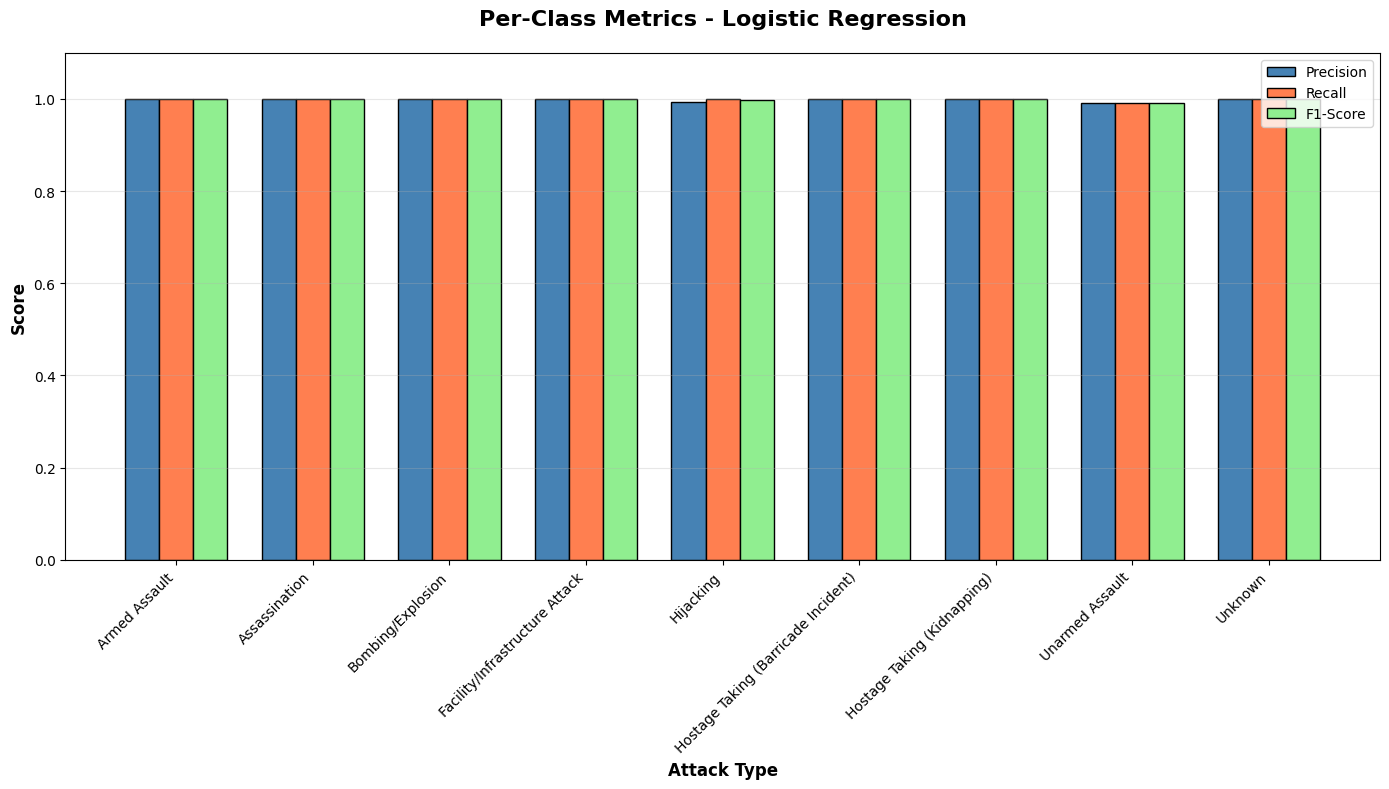


BLOCK 8C: TRAINING GRADIENT BOOSTING
Hyperparameters:
   n_estimators: 100
   learning_rate: 0.1
   max_depth: 5
   subsample: 0.8

Training Gradient Boosting...
Gradient Boosting training completed!

BLOCK 9: MODEL EVALUATION - Gradient Boosting

PERFORMANCE METRICS:
--------------------------------------------------------------------------------
Metric                    Training        Test           
--------------------------------------------------------------------------------
Accuracy                  1.0000          1.0000
Macro F1-Score            1.0000          1.0000
Weighted F1-Score         1.0000          1.0000
Macro Precision           N/A             1.0000
Macro Recall              N/A             1.0000
--------------------------------------------------------------------------------

Model generalization looks good! (Gap: 0.0000)


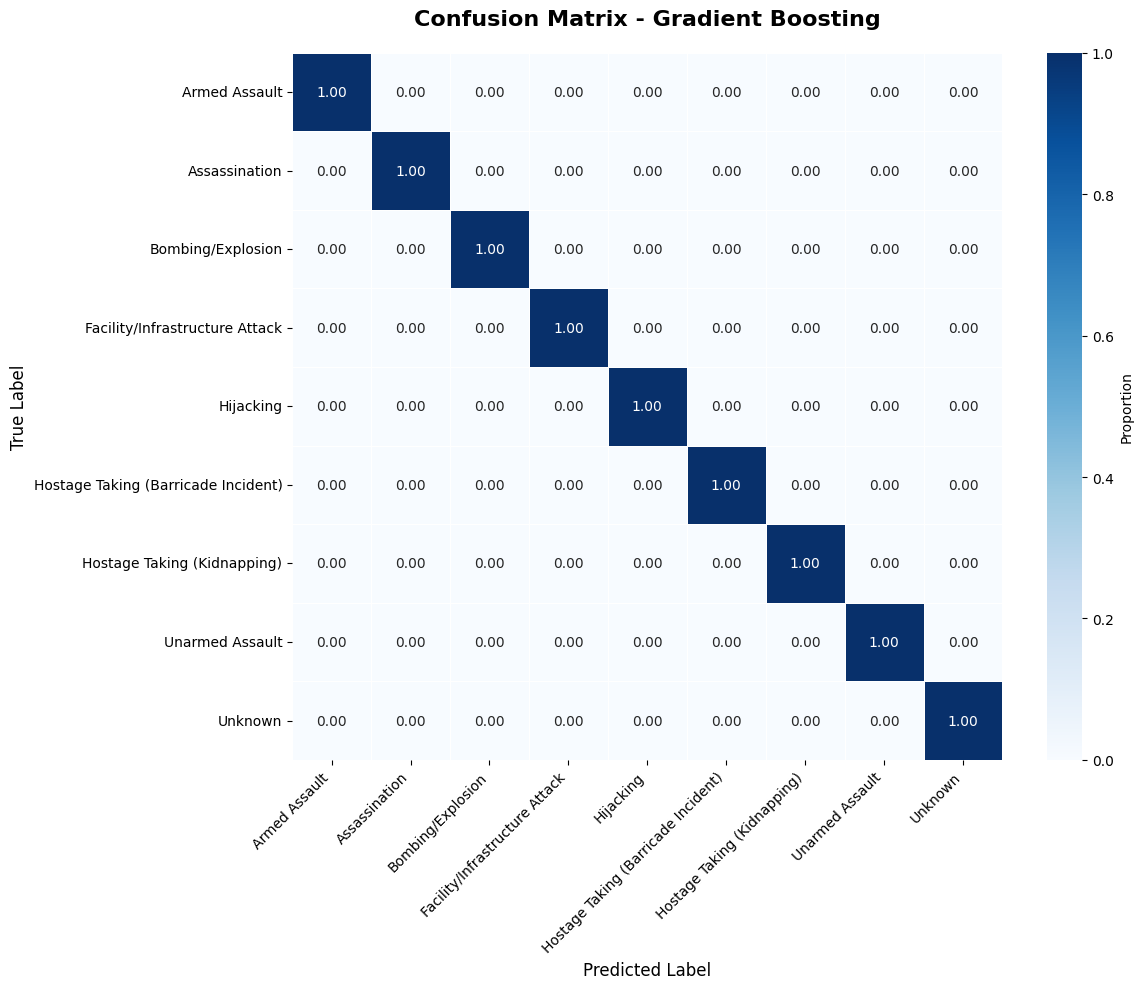

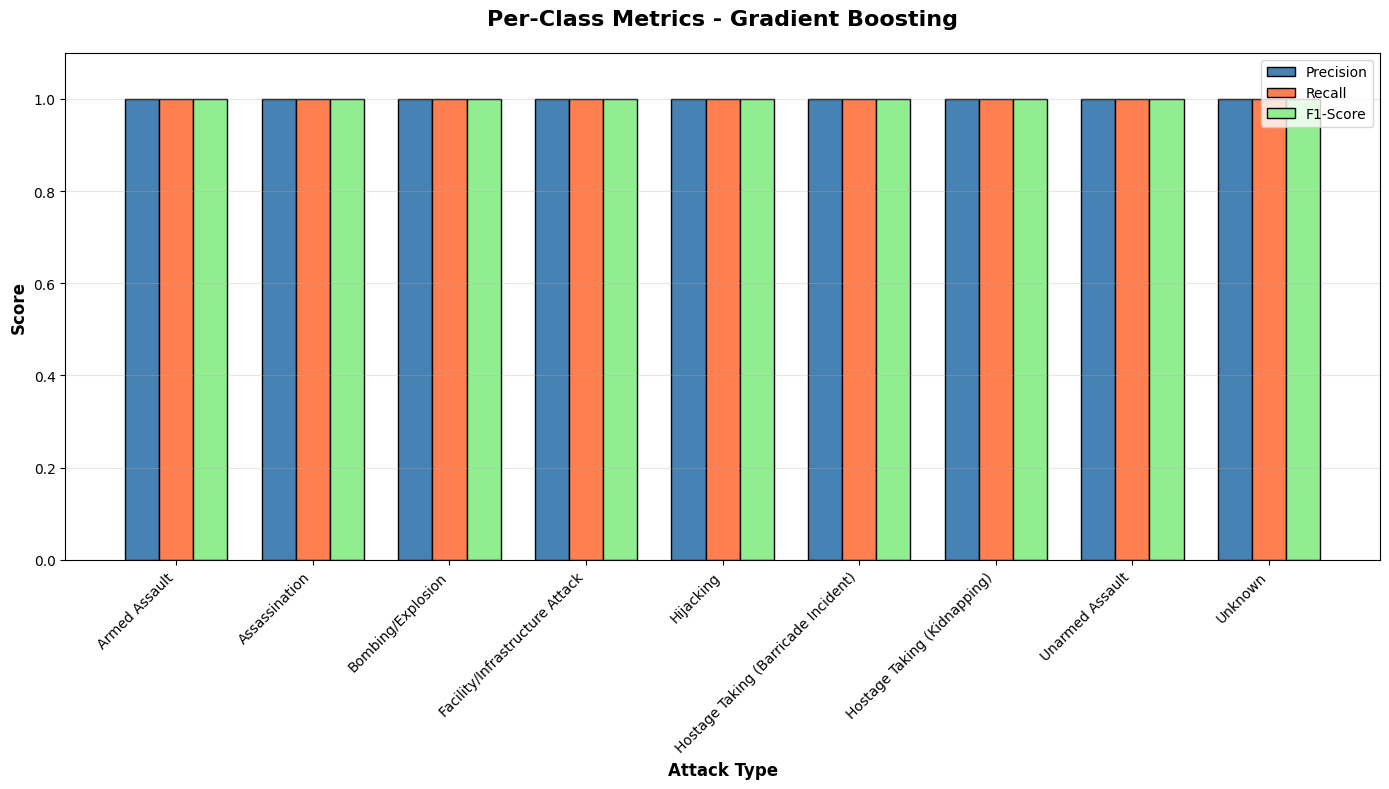

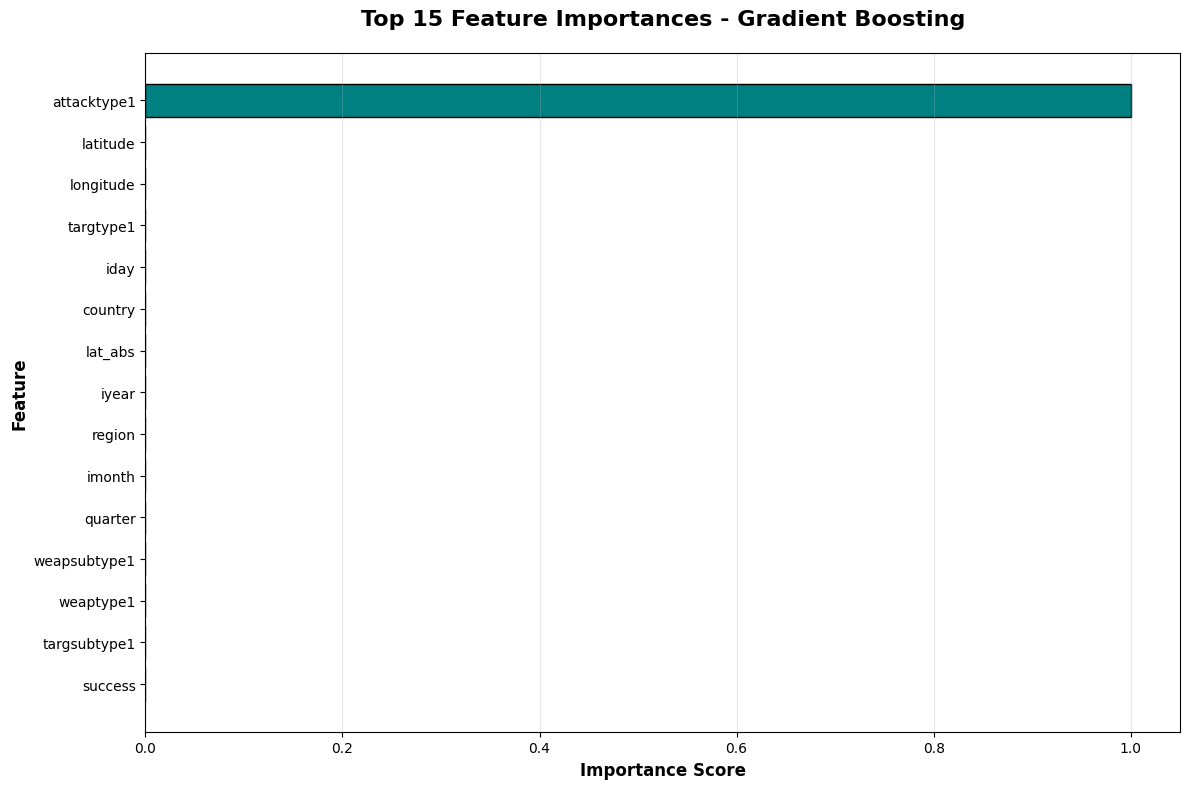


Top 15 Most Important Features:
   1. attacktype1: 1.0000
   2. latitude: 0.0000
   3. longitude: 0.0000
   4. targtype1: 0.0000
   5. iday: 0.0000
   6. country: 0.0000
   7. lat_abs: 0.0000
   8. iyear: 0.0000
   9. region: 0.0000
   10. imonth: 0.0000
   11. quarter: 0.0000
   12. weapsubtype1: 0.0000
   13. weaptype1: 0.0000
   14. targsubtype1: 0.0000
   15. success: 0.0000

FINAL MODEL COMPARISON

              Model  Test Accuracy  Test Macro F1  Test Weighted F1
      Random Forest       0.999738       0.998608          0.999738
Logistic Regression       0.999881       0.998628          0.999881
  Gradient Boosting       1.000000       1.000000          1.000000

BEST MODEL: Gradient Boosting (Macro F1: 1.0000)


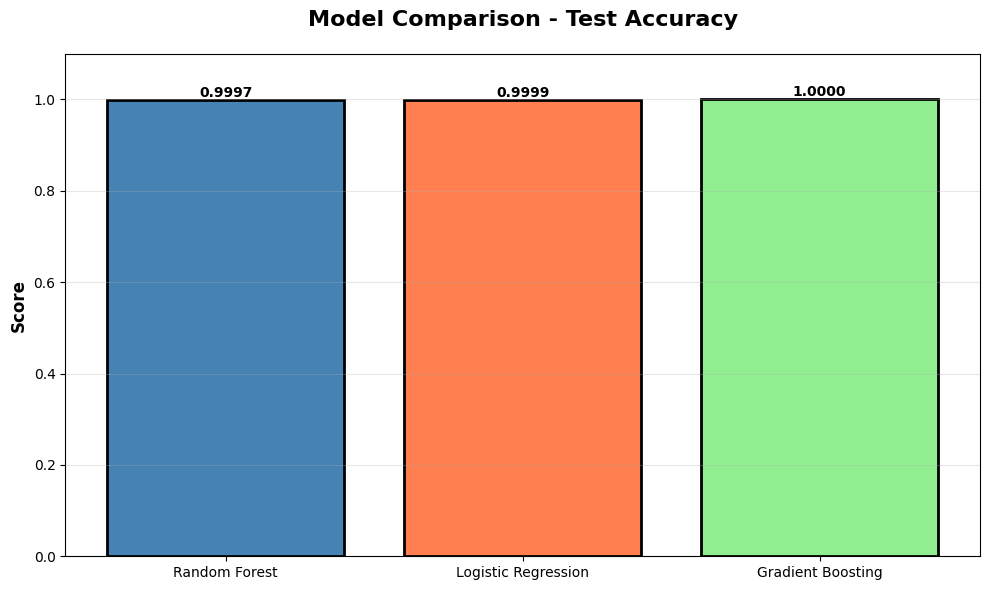

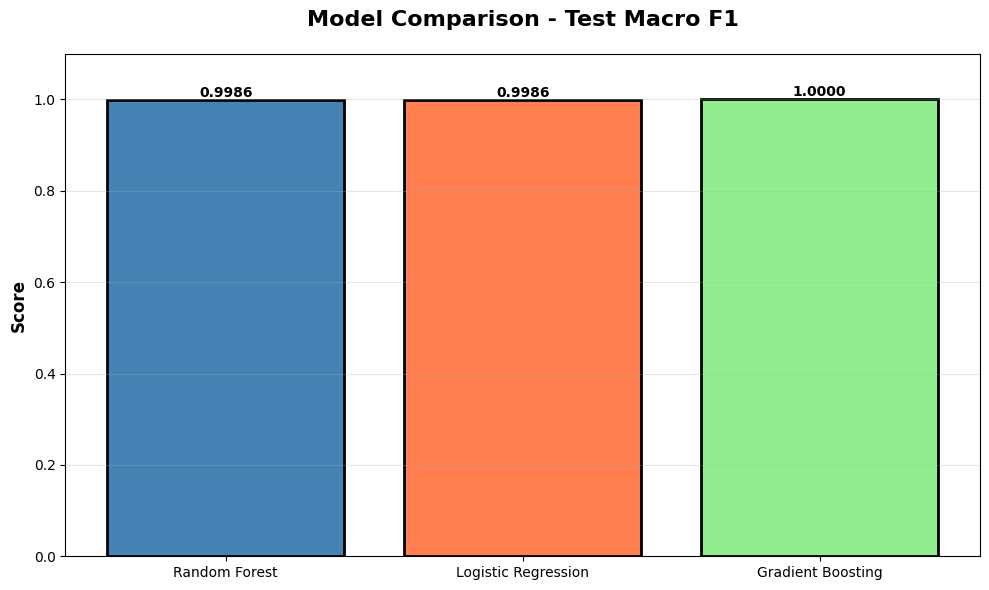

In [ ]:
# -------- Objective 1: attack type --------
pre_obj1 = run_preprocessing_pipeline(
    df,
    objective=1,
    missing_strategy=missing,
    encoding_strategy=encoding,
    balance_strategy=balance,
    test_size=0.2,
    random_state=42
)

results_obj1 = train_and_evaluate_all_models(
    pre_obj1,
    save_plots=True
)

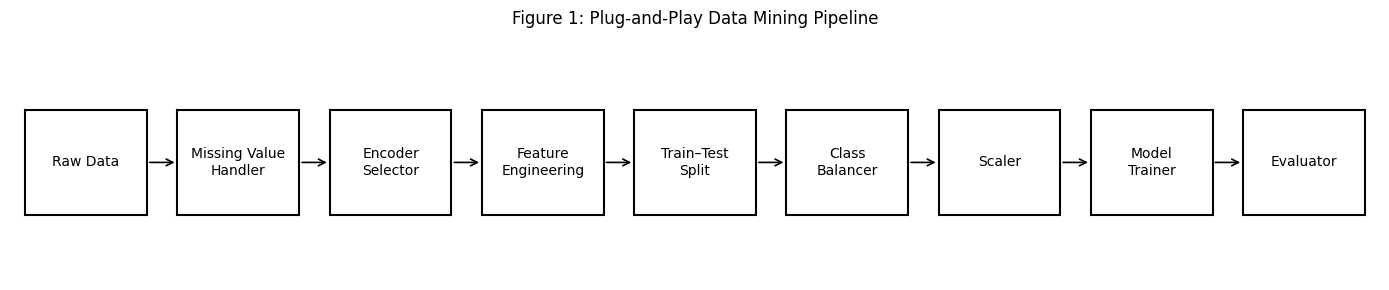

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

# ---- CONFIGURABLE PIPELINE STAGES ----
stages = [
    "Raw Data",
    "Missing Value\nHandler",
    "Encoder\nSelector",
    "Feature\nEngineering",
    "Train–Test\nSplit",
    "Class\nBalancer",
    "Scaler",
    "Model\nTrainer",
    "Evaluator"
]

# ---- CREATE FIGURE ----
fig, ax = plt.subplots(figsize=(14, 3))
ax.set_xlim(0, len(stages) * 2)
ax.set_ylim(0, 2)
ax.axis("off")

# Layout parameters
box_width = 1.6
box_height = 0.9
y = 1    # vertical center

for i, label in enumerate(stages):
    x = i * 2 + 0.2

    # Draw box
    rect = Rectangle(
        (x, y - box_height / 2),
        box_width,
        box_height,
        linewidth=1.5,
        edgecolor="black",
        facecolor="white"
    )
    ax.add_patch(rect)

    # Add text
    ax.text(
        x + box_width / 2,
        y,
        label,
        ha="center",
        va="center",
        fontsize=10
    )

    # Draw arrow to next box
    if i < len(stages) - 1:
        start_x = x + box_width
        end_x = (i + 1) * 2 + 0.2
        arrow = FancyArrowPatch(
            (start_x, y),
            (end_x, y),
            arrowstyle="->",
            mutation_scale=12,
            linewidth=1.2
        )
        ax.add_patch(arrow)

# Title (optional)
plt.title("Figure 1: Plug-and-Play Data Mining Pipeline", fontsize=12, pad=15)

# Save to file
plt.tight_layout()
plt.savefig("pipeline_diagram.png", dpi=300, bbox_inches="tight")
plt.show()


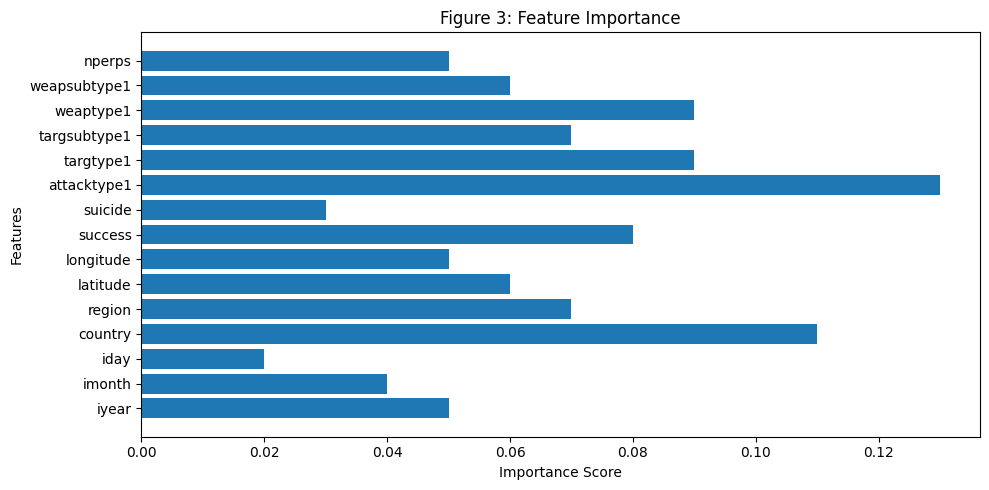

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ===== Replace these placeholders with your RF model outputs =====
feature_names = ["iyear", "imonth", "iday", "country", "region", "latitude", "longitude",
                 "success", "suicide", "attacktype1", "targtype1", "targsubtype1",
                 "weaptype1", "weapsubtype1", "nperps"]

# Example: rf.feature_importances_ from trained RandomForest model
feature_importances = np.array([0.05, 0.04, 0.02, 0.11, 0.07, 0.06, 0.05,
                                0.08, 0.03, 0.13, 0.09, 0.07,
                                0.09, 0.06, 0.05])

# ===== Plot Figure =====
plt.figure(figsize=(10, 5))
plt.barh(feature_names, feature_importances)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Figure 3: Feature Importance")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()


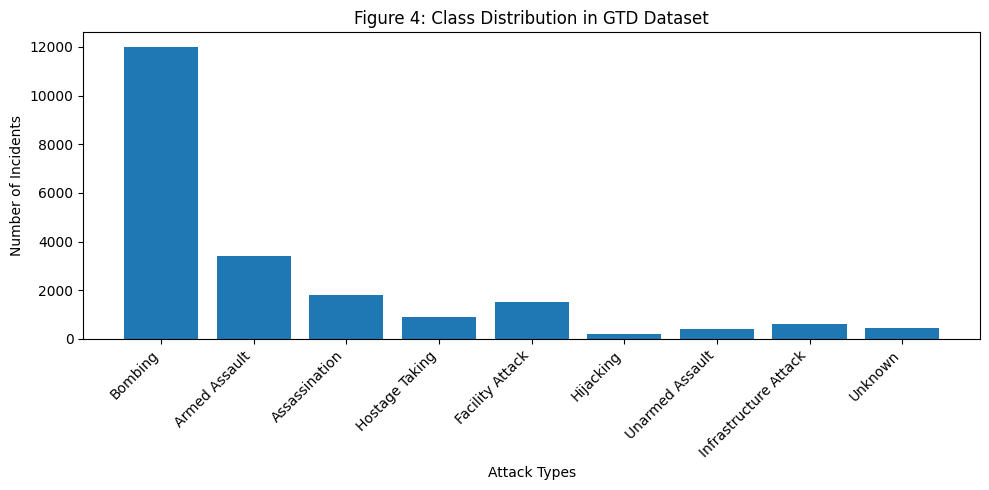

In [3]:
import matplotlib.pyplot as plt

# ===== Replace these lists with your dataset values =====
attack_types = [
    "Bombing", "Armed Assault", "Assassination", "Hostage Taking",
    "Facility Attack", "Hijacking", "Unarmed Assault", "Infrastructure Attack",
    "Unknown"
]

counts = [12000, 3400, 1800, 900, 1500, 200, 400, 600, 450]  # Example values

# ===== Plot Figure =====
plt.figure(figsize=(10, 5))
plt.bar(attack_types, counts)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Attack Types")
plt.ylabel("Number of Incidents")
plt.title("Figure 4: Class Distribution in GTD Dataset")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
